In [1]:
import cv2 as cv
from Visualization import *
from hough_detect import *
import numpy as np
from PIL import Image

Visualization.py loaded


In [2]:
def gamma(img,lut,gray=False):
    PolerImg = img.copy()
    if not gray:
        for x in range(len(img)):
            for y in range(len(img[0])):
                PolerImg[x][y][0] = lut[img[x][y][0]]
                PolerImg[x][y][1] = lut[img[x][y][1]]
                PolerImg[x][y][2] = lut[img[x][y][2]]
        return PolerImg
    else:
        for x in range(len(img)):
            for y in range(len(img[0])):
                PolerImg[x][y]= lut[img[x][y]]
        return PolerImg

In [3]:
%ls *.MOV

IMG_0250.MOV*  IMG_0307.MOV*


In [4]:
vid = cv.VideoCapture('IMG_0307.MOV')
for i in range(100):
    sucess, orignal_frame = vid.read()

In [5]:
h, w, c = orignal_frame.shape

## Original Image

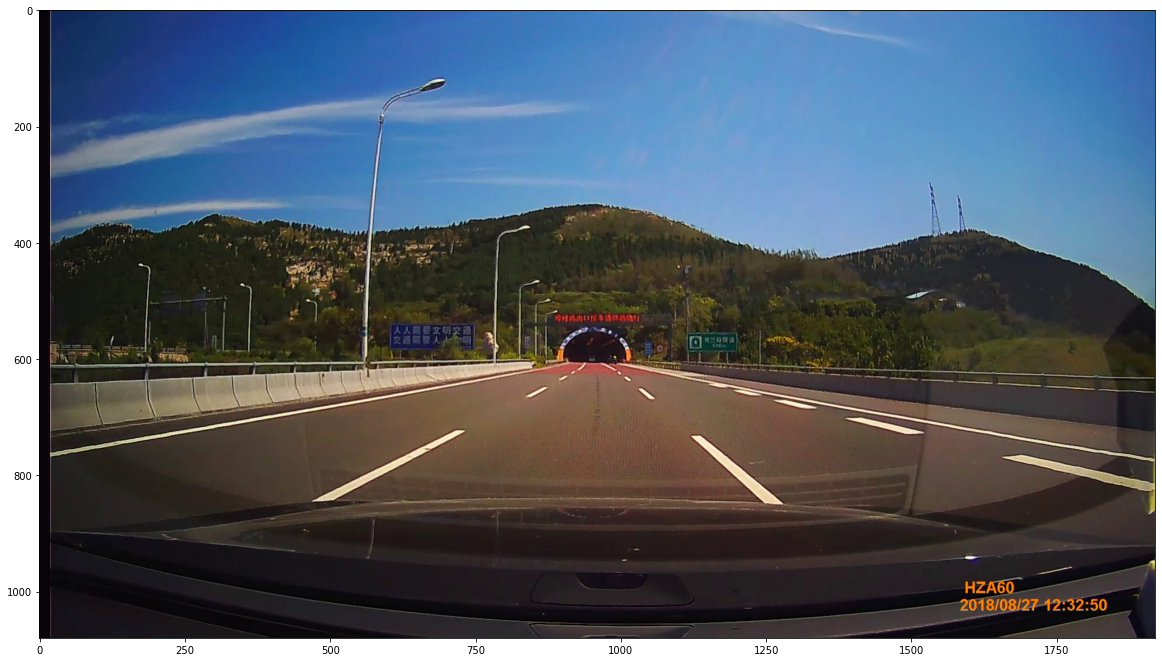

In [6]:
PLTdraw(orignal_frame)

## Croped Image
Crop out unnesseary part, at lease for our base case

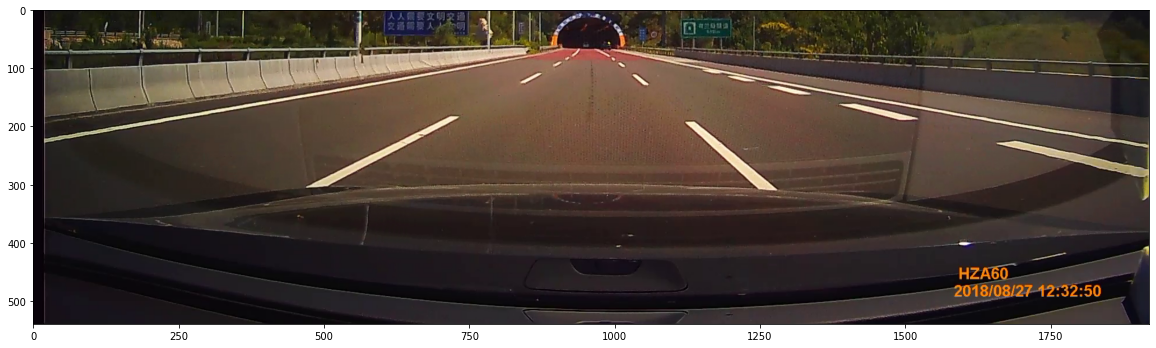

In [7]:
frame = orignal_frame[int(h/2):]
PLTdraw(frame)

## Grayed Image
Average of three channels

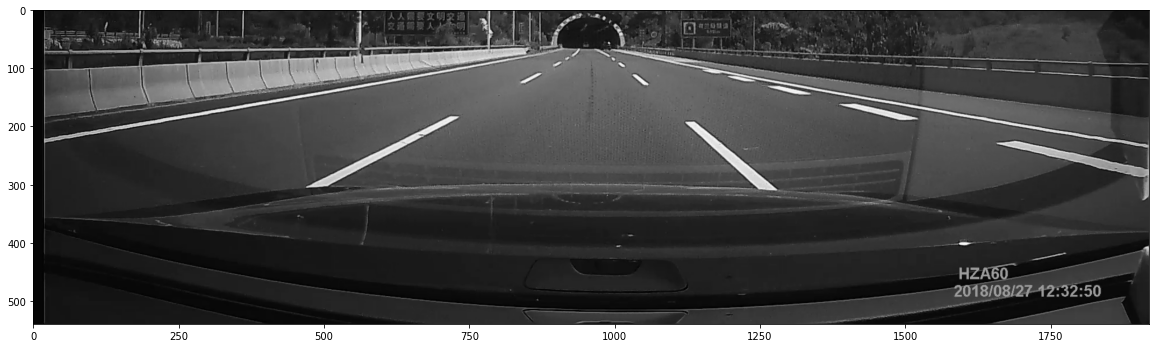

In [8]:
grayed_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
PLTdraw(grayed_frame)

In [9]:
def get_lut(power=3):
    table = np.array([(pow(i / 255.0, power) * 255) for i in np.arange(0, 256)]).astype("uint8")
    return table

## Gamma Corrected Image
Make light part lighter, dark part darker

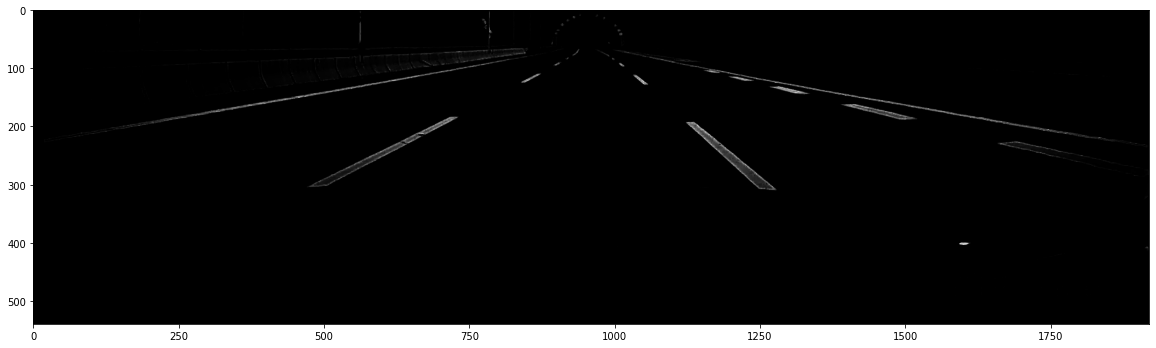

In [10]:
look_up_table = get_lut(power=11)
gamma_correct_grayed_frame = cv.LUT(grayed_frame,look_up_table)
PLTdraw(gamma_correct_grayed_frame)

## Thresholded Image
Convert image in to binary given some threshold method

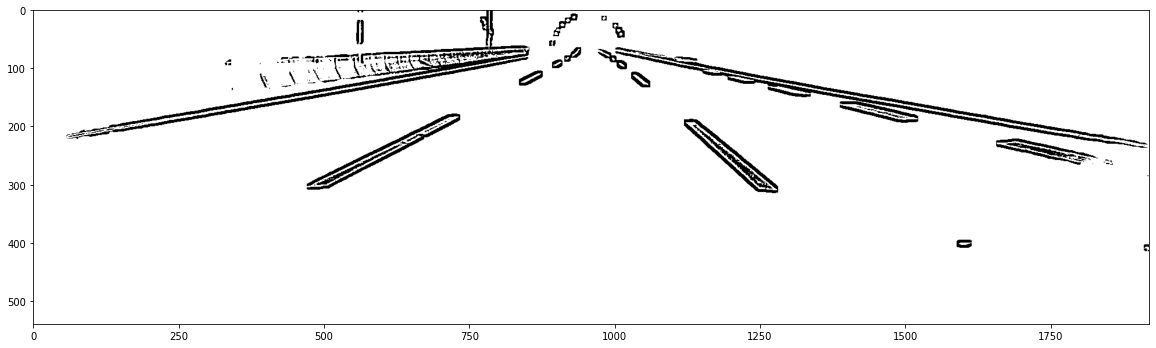

In [11]:
threshed_gamma_correct_grayed_frame = cv.adaptiveThreshold(
    gamma_correct_grayed_frame,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,3)
PLTdraw(threshed_gamma_correct_grayed_frame)

## Edge Detection
Find all edges in the processed image

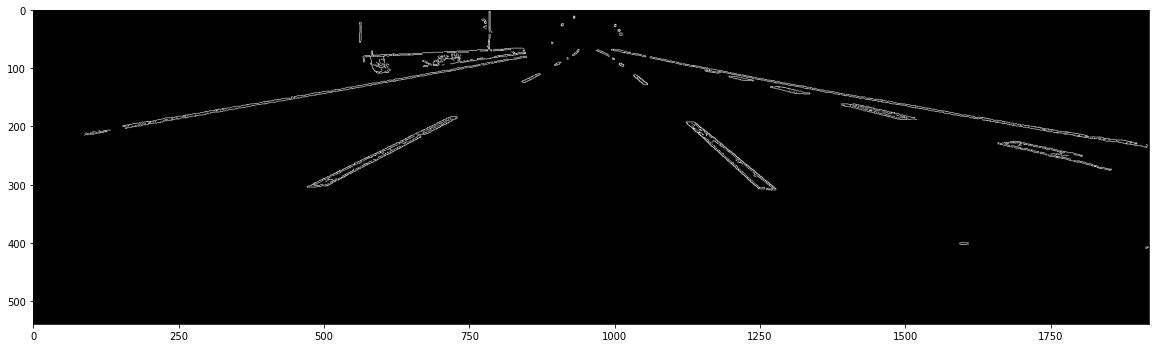

In [12]:
canny_gamma_correct_grayed_frame = cv.Canny(gamma_correct_grayed_frame,0,255)
PLTdraw(canny_gamma_correct_grayed_frame)

### TODO
Gain an indepths understanding of thresholding methods and impolment it myself

In [13]:
hough_space, theta, rho = hough_line(canny_gamma_correct_grayed_frame)

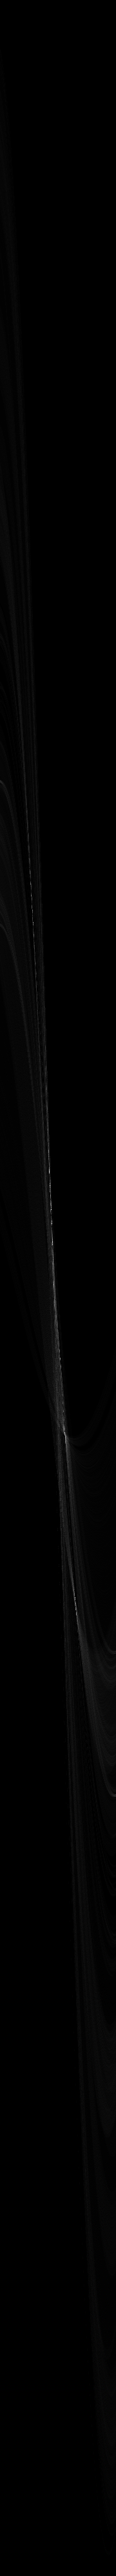

In [14]:
Image.fromarray(hough_space)

In [15]:
np.unravel_index(hough_space.argmax(), hough_space.shape)

(1813, 76)

In [16]:
test = hough_peaks(hough_space, 2)

In [17]:
test

array([[2473,  116],
       [1813,   76]])

In [13]:
def hough_intersect (rho, theta, image):
    h, w = image.shape[:2]
    out = []
    theta = math.radians(theta)
    intersect = [int(round(rho / math.sin(theta))), int(round((rho - w * math.cos(theta)) / math.sin(theta))), int(round(rho / math.cos(theta))),
                 int(round((rho - h * math.sin(theta)) / math.cos(theta)))]
    if (intersect[0] > 0) and (intersect[0] < h):
        out.append((0, intersect[0]))
    if (intersect[1] > 0) and (intersect[1] < h):
        out.append((w, intersect[1]))

    if (intersect[2] > 0) and (intersect[2] < w):
        out.append((intersect[2], 0))
    if (intersect[3] > 0) and (intersect[3] < w):
        out.append((intersect[3], h))
    #print(out)
    return out

In [14]:
def Hough_lines(img, line_length=50):

    height, width = img.shape[:2]
    accumulator = np.zeros((180, int(math.sqrt(height ** 2 + width ** 2))), dtype=np.int)

   
    lines = np.array([[0, 0], [0, 0]])

    #line_length = 40

    # look for every pixel
    for y in range(0, height):
        for x in range(0, width):
            # if pixel is black (possible part of a line)
            if img[y][x] > 5:
                line = []
                # try all angles 
                for theta in range(0, 180):
                    p = int(x * math.cos(math.radians(theta)) + y * math.sin(math.radians(theta)))
                    accumulator[theta][p] += 1
                    # Check if it looks like line and if it's not in a list
                    if (accumulator[theta][p] > line_length) and (p not in lines[:, 0]) and (theta not in  lines[:, 1]):
                        lines = np.vstack((lines, np.array([p, theta])))

    # clean two first zeros
    lines = np.delete(lines, [0, 1], axis=0)

    return lines

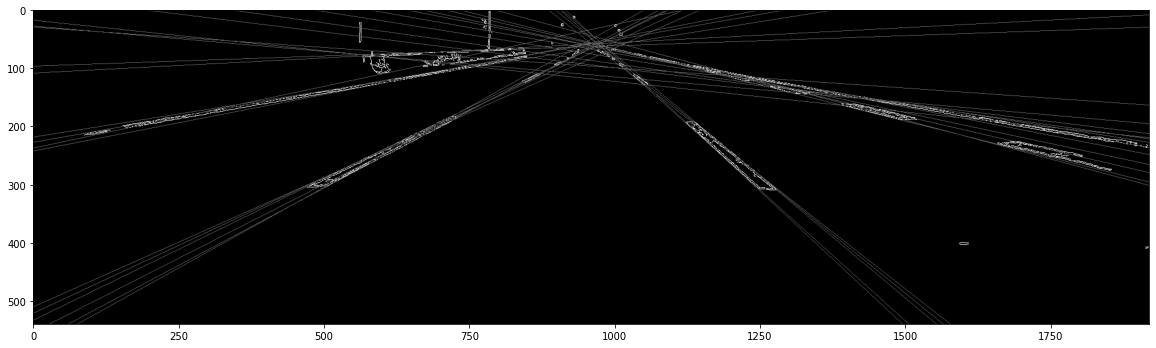

In [15]:
hough_space = Hough_lines(canny_gamma_correct_grayed_frame, 100)
#print(hough_space)

for i in hough_space:
    points = hough_intersect(i[0], i[1], canny_gamma_correct_grayed_frame)
    #print(points)
    cv.line(canny_gamma_correct_grayed_frame, points[0], points[1], [100])

PLTdraw(canny_gamma_correct_grayed_frame)
#cv.imshow('image', canny_gamma_correct_grayed_frame)